In [40]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline


We read in all of the data and set the targets and features.

In [2]:
sel_targets= pd.read_csv('GalaxyProperties-targets.csv')
print(sel_targets.head(10))
sel_targets.shape

(1000, 5)

In [3]:
spectra = pd.read_csv('spectra-feats.csv', header = None, delimiter=" ")
print(spectra)
spectra.shape


          0         1         2         3         4         5         6    \
0    0.010532  0.011854  0.011477  0.011186  0.010723  0.007781  0.003281   
1    0.012205  0.013479  0.013350  0.013067  0.013404  0.011026  0.005107   
2    0.003660  0.004010  0.004001  0.003920  0.004109  0.003515  0.001691   
3    0.065447  0.071665  0.071253  0.069657  0.072569  0.061464  0.029246   
4    0.143073  0.156413  0.155725  0.152241  0.159254  0.135972  0.065265   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.084785  0.092999  0.092949  0.091197  0.095809  0.082226  0.039687   
996  0.014452  0.015888  0.016062  0.015868  0.017012  0.015016  0.007340   
997  0.153889  0.168172  0.167482  0.163732  0.171433  0.146658  0.070557   
998  0.025145  0.027639  0.027524  0.026976  0.028090  0.023713  0.011243   
999  0.046592  0.051136  0.051223  0.050333  0.053077  0.045830  0.022268   

          7         8         9    ...       840       841       842  \
0  

(1000, 850)

In [4]:
wavelengths = np.loadtxt('Wavelengths.txt')
wavelengths.shape

(850,)

Organized our features into their own category so that they can be modeled seperatly. I will be focusing on dust and tau for my portion of the project.

In [26]:
dust = sel_targets[['Dust attenuation value']]
age = sel_targets[['Age (Gyr)']]
mass_log10  = sel_targets[['Log10(Mass/Mass_Sun)']]
tau = sel_targets[['Tau (Gyr)']]

(1000, 1)


$\textbf{Dust}$

In [27]:
scores = cross_validate(RandomForestRegressor(random_state = 10),spectra,dust,cv = KFold(n_splits=5, shuffle=True, random_state=10), \
               return_train_score=True)

/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataCon

In [28]:
print(np.round(np.mean(scores['test_score']),3), np.round(np.std(scores['test_score']),3))

0.853 0.062


In [29]:
print(np.round(np.mean(scores['train_score']),3), np.round(np.std(scores['train_score']),3))

0.981 0.002


As can be seen above, I decided to utilize RandomForestRegressor just as a baseline to see where we are with our data and how well it can be modeled. I got a training score of 0.981 and a test score of 0.853, which tells me that there is a lot of varience in our model. 

In [30]:
pred = cross_val_predict( RandomForestRegressor(random_state = 5), spectra,dust, cv =  KFold(n_splits=5, shuffle=True, random_state=10))
metrics.r2_score(dust, pred)

/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1068: Dat

0.8400445460542572

Text(0, 0.5, 'Predictions')

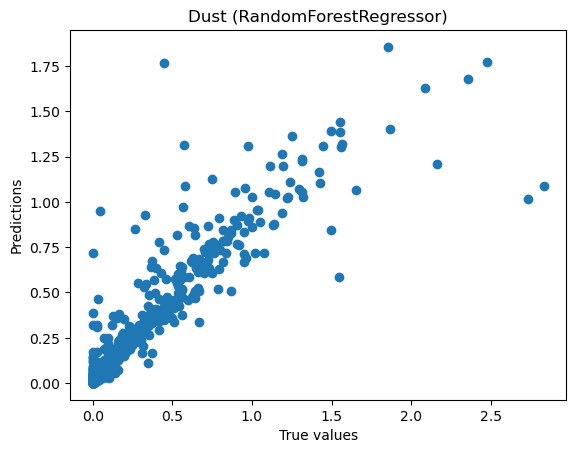

In [31]:
plt.scatter(dust,pred)
plt.title('Dust (RandomForestRegressor)')
plt.xlabel('True values')
plt.ylabel('Predictions')

I then attempted to use the HGB Regressor.

In [32]:
parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(HistGradientBoostingRegressor(max_bins = 100), parameters, 
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(spectra,dust.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   1.0s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.9s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.2s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.2s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.4s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.4s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.3s
[CV] END

In [33]:
#Hist GBR scores

scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
38,"{'learning_rate': 0.5, 'loss': 'squared_error'...",0.858091,0.050175,0.995115
20,"{'learning_rate': 0.3, 'loss': 'squared_error'...",0.857545,0.036792,0.987448
2,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.857062,0.046551,0.945880
37,"{'learning_rate': 0.5, 'loss': 'squared_error'...",0.856736,0.049958,0.983924
23,"{'learning_rate': 0.3, 'loss': 'squared_error'...",0.855599,0.043880,0.989466


As can be seen from the results above, it did not do much in reducing the variance and appears to have overfitted the data, increasing the variance even further. Therefore, I gave XGB an attempt.

In [34]:
parameters = {'max_depth':[6,10,None], 'n_estimators':[50, 100, 200,500], 
              'learning_rate': [0.02,0.05,0.1,0.3], 'objective':['reg:squarederror',
                'reg:squaredlogerror'], 'subsample':[0.5,1]}

nmodels = np.product([len(el) for el in parameters.values()])
model = RandomizedSearchCV(xgb.XGBRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True, n_iter = 30)
model.fit(spectra,dust.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END learning_rate=0.05, max_depth=None, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   5.7s
[CV] END learning_rate=0.05, max_depth=None, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   5.8s
[CV] END learning_rate=0.05, max_depth=None, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   6.4s
[CV] END learning_rate=0.05, max_depth=None, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   6.4s
[CV] END learning_rate=0.05, max_depth=None, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   6.6s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=200, objective=reg:squaredlogerror, subsample=0.5; total time=  13.7s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=200, objective=reg:squaredlogerror, subsample=0.5; total time=  13.4s
[CV] END learning_rate=0.05, max_depth=6, n_esti

In [35]:
#xgb.XGBRegressor scores

scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
13,"{'subsample': 0.5, 'objective': 'reg:squareder...",0.915489,0.039966,0.998310
25,"{'subsample': 0.5, 'objective': 'reg:squareder...",0.903994,0.035538,0.999998
24,"{'subsample': 0.5, 'objective': 'reg:squareder...",0.903638,0.039948,0.999998
28,"{'subsample': 0.5, 'objective': 'reg:squareder...",0.899499,0.034699,0.997728
27,"{'subsample': 0.5, 'objective': 'reg:squareder...",0.894483,0.038531,0.982112


Utilizing XGB with RandomizedSearchCV took about 17 minutes to run on my machine, but produced, to my mind, decent scores. I believe that a runtime of ~ 17 minutes is not ideal, but because I had the time to wait and see how good the cores could be, it turned out in my favor. I could reduce the amount of time it takes to run by reducing the size of the features and target, but that will introduce some bias to the system and could also alter the scores negatively, making me believe that this model is not the best one when it could very well be. 

$\textbf{Tau}$

After talking amongst the class and with Professor Maller it became apparent that some form of transformation needed to be done to the data, therefore I took the log10 of tau.

In [39]:
log_tau = np.log10(tau)
log_tau

,Tau (Gyr)
0,-1.481020
1,-1.059753
2,0.105160
3,-0.615130
4,-0.291849
...,...
995,0.315953
996,-1.201727
997,-0.036853
998,-0.773986


I utilized Random Forest Regressor just as a baseline, to see where things stand.

In [8]:
scores = cross_validate(RandomForestRegressor(random_state = 20),spectra,log_tau,cv = KFold(n_splits=5, shuffle=True, random_state=10), \
               return_train_score=True)

/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataCon

In [9]:
print(np.round(np.mean(scores['test_score']),3), np.round(np.std(scores['test_score']),3))

0.543 0.048


In [10]:
print(np.round(np.mean(scores['train_score']),3), np.round(np.std(scores['train_score']),3))

0.939 0.002


As can be seen, the scores produced were not good at all, therefore I decided to scale the data.

In [42]:
scaler = StandardScaler()
standardized_features = scaler.fit_transform(spectra)


In [49]:
pca = PCA(n_components = 400 )
reduced_spectra= pca.fit_transform(standardized_features)

In [44]:
parameters = {'max_depth':[6,10,None], 'n_estimators':[50, 100, 200,500], 
              'learning_rate': [0.02,0.05,0.1,0.3], 'objective':['reg:squarederror',
                'reg:squaredlogerror'], 'subsample':[0.5,1]}

nmodels = np.product([len(el) for el in parameters.values()])
model = RandomizedSearchCV(xgb.XGBRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True, n_iter = 30)
model.fit(reduced_spectra,log_tau.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END learning_rate=0.02, max_depth=None, n_estimators=50, objective=reg:squarederror, subsample=0.5; total time=   1.2s
[CV] END learning_rate=0.02, max_depth=None, n_estimators=50, objective=reg:squarederror, subsample=0.5; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=6, n_estimators=100, objective=reg:squaredlogerror, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=50, objec

/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/home/claudio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/claudio/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/claudio/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/home/claudio/anaconda3/lib/pyth

Best params, best score: 0.8357 {'subsample': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 500, 'max_depth': None, 'learning_rate': 0.02}


My first attempt was running xgb, just because it worked well for me with dust and I wanted to see if the trend would continue. The score itself is not poor at a test score of 0.83, but due to the errors that occured when validating the mode (likely to the negative values of log_tau), I did not want to use it.

In [57]:
parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'n_estimators':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(GradientBoostingRegressor(), parameters, 
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(reduced_spectra,log_tau.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   1.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   1.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   1.9s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   1.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=20; total time=   1.9s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   4.9s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   4.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   4.8s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_estimators=50; total time=   5.0s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, n_es

In [58]:
#GBR scores

scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
2,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.826202,0.014619,0.999207
17,"{'learning_rate': 0.1, 'loss': 'absolute_error...",0.821656,0.027335,0.980243
1,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.819588,0.015056,0.996596
20,"{'learning_rate': 0.3, 'loss': 'squared_error'...",0.811238,0.021421,0.999991
19,"{'learning_rate': 0.3, 'loss': 'squared_error'...",0.810016,0.018133,0.999697


Utilizing the Gradient Boosting Regressor with GridSearchCV (runtime ~14 min) I retrieved scores that I would not say are ideal. The difference between the mean test score and train score is very severe, therefore I chose one more method to try.

In [102]:
parameters = {'max_depth':[6,10,None], 'loss':['squared_error','absolute_error'], 
              'max_iter':[20,50,100], 'learning_rate': [0.1,0.3,0.5]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(HistGradientBoostingRegressor(max_bins = 100), parameters, 
                     cv = KFold(n_splits=5, shuffle=True, random_state = 5), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(reduced_spectra,log_tau.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.6s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.6s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.7s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=20; total time=   0.5s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.0s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.1s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.1s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   0.9s
[CV] END learning_rate=0.1, loss=squared_error, max_depth=6, max_iter=50; total time=   1.0s
[CV] END

In [103]:
#Hist GBR scores 

scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV.head()

,params,mean_test_score,std_test_score,mean_train_score
5,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.826839,0.016365,0.997716
2,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.826774,0.021346,0.997045
8,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.824408,0.016368,0.997903
4,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.823954,0.017155,0.987217
1,"{'learning_rate': 0.1, 'loss': 'squared_error'...",0.823155,0.020354,0.981962


The scores between the GBR and HistGBR are almost 1:1, but the run time for HistGBR was only 1 min 54 sec, which is  x14 quicker than GBR. After discussing with my peers we agreed that the test score of 0.82 was a suitable result. Although the test scores are not ideal, we beliave that it is the best possible outcome given the constraints of the project.